In [54]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
%load_ext tensorboard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
from PIL.Image import *
import urllib.request


print(tf.__version__)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.4.0


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


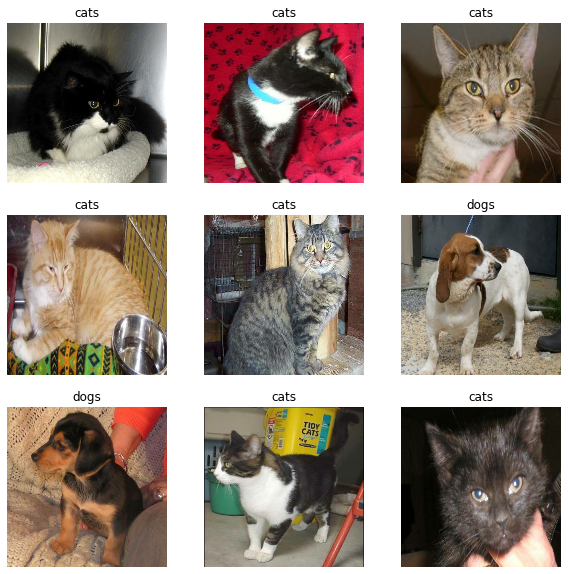

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


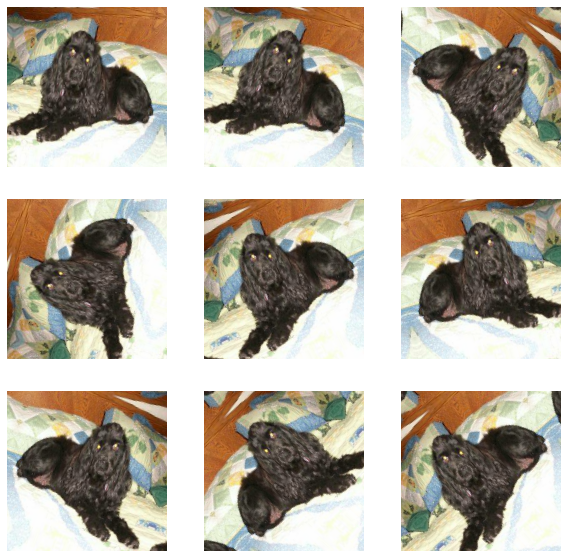

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [14]:
# Freeze the pre-trained model weights
base_model.trainable = True


# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = maxpool_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Layer classification head with feature detector

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = maxpool_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

learning_rate = 0.0001



# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
)

(32, 1280)
(32, 1)
Number of layers in the base model:  154


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [16]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 11s 353ms/step - loss: 1.7019 - accuracy: 0.5150


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 1.62
initial accuracy: 0.52


In [23]:
# Train the model with the new callback

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history= model.fit(train_dataset,  
          epochs=initial_epochs,
          validation_data=validation_dataset,
          callbacks=[tensorboard_callback])  

%tensorboard --logdir logs

Epoch 1/10
63/63 [==============================] - 57s 911ms/step - loss: 0.0578 - accuracy: 0.9800 - val_loss: 0.1524 - val_accuracy: 0.9728
Epoch 2/10
63/63 [==============================] - 55s 879ms/step - loss: 0.0737 - accuracy: 0.9790 - val_loss: 0.1645 - val_accuracy: 0.9740
Epoch 3/10
63/63 [==============================] - 52s 817ms/step - loss: 0.0536 - accuracy: 0.9825 - val_loss: 0.2822 - val_accuracy: 0.9443
Epoch 4/10
63/63 [==============================] - 58s 914ms/step - loss: 0.0683 - accuracy: 0.9780 - val_loss: 0.2168 - val_accuracy: 0.9567
Epoch 5/10
63/63 [==============================] - 54s 854ms/step - loss: 0.0843 - accuracy: 0.9765 - val_loss: 0.3151 - val_accuracy: 0.9505
Epoch 6/10
63/63 [==============================] - 54s 851ms/step - loss: 0.0575 - accuracy: 0.9835 - val_loss: 0.2126 - val_accuracy: 0.9542
Epoch 7/10
63/63 [==============================] - 53s 841ms/step - loss: 0.0286 - accuracy: 0.9885 - val_loss: 0.2480 - val_accuracy: 0.9542

Reusing TensorBoard on port 6006 (pid 21054), started 0:29:53 ago. (Use '!kill 21054' to kill it.)

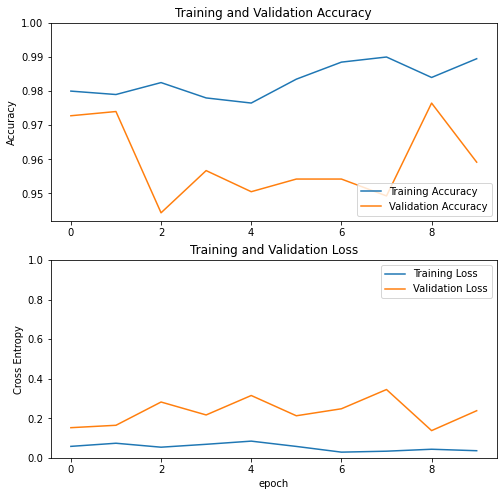

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)



6/6 [==============================] - 2s 336ms/step - loss: 0.2534 - accuracy: 0.9531
Test accuracy : 0.953125


Predictions:
 [0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1]
Labels:
 [1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1]


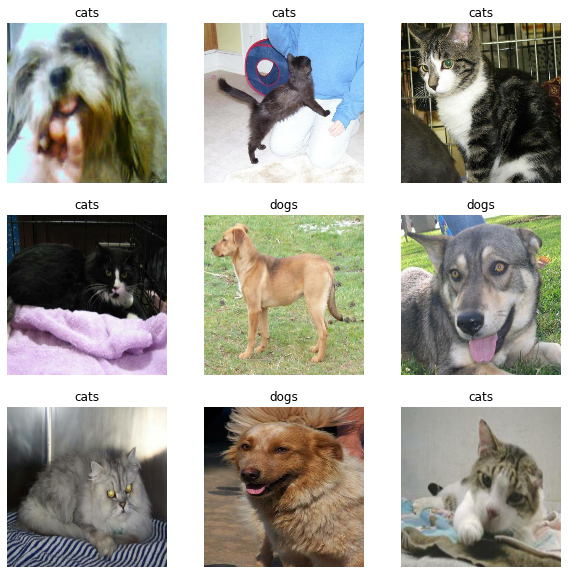

In [26]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [27]:
model.save('my_model2.h5')


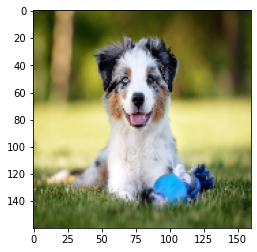

(1, 160, 160, 3)


In [58]:
#img_path = 'https://live.staticflickr.com/5504/14187029688_46e25edbf1_k.jpg'
img_path = 'https://www.jardiner-malin.fr/wp-content/uploads/2019/03/berger-australien-1.jpg'
im=urllib.request.urlretrieve(img_path, "sample.png")

img = tf.keras.preprocessing.image.load_img("sample.png", target_size=(160, 160))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [59]:
# predicting images
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict_on_batch(images).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(classes)
predictions = tf.where(classes < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print("Predicted class is:",class_names[predictions[0]])

Predictions:
 [1]
Predicted class is: dogs


In [63]:
layer_names = [layer.name for layer in base_model.layers]
layer_names

['input_1',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_e

In [64]:
base_model.layers

In [65]:
layer_outputs = [layer.output for layer in base_model.layers]

In [66]:
layer = tf.Graph().get_tensor_by_name('tensor_layer:0')
# image can visualize 1, 3 and 4 channel images
tf.summary.image('layer output', layer[:, :, :, 0:3], max_output=3)

KeyError: "The name 'tensor_layer:0' refers to a Tensor which does not exist. The operation, 'tensor_layer', does not exist in the graph."